Тестовое задание Из текста книги http://az.lib.ru/k/kipling_d_r/text_0070.shtml вырезать все лишнее не относящееся к тексту (лицензии и т.п.).

Найти top 100 самых часто используемые нормализованных слов в тексте.

Найти все формы слова для top 10 самых часто используемые нормализованных слов в тексте.

Найти все имена собственные.

Задание выполнить в виде jupyter notebook и разместить его в git репозитории на github

In [1]:
import pandas as pd
import requests
import re 

import warnings
warnings.filterwarnings("ignore")

In [2]:
def findall_between(base_string: str, start: str='data-id=', end: str='>'):
    return re.findall('%s(.*)%s' % (start, end), str(base_string))

In [3]:
from typing import List, Tuple, Set
from pymorphy2 import MorphAnalyzer
from stop_words import get_stop_words

class Preprocessor:

    def __init__(self, morph=None, stop_words=None):
        self.morph = morph if morph else MorphAnalyzer()
        self.stop_words = stop_words if stop_words else get_stop_words("russian")
        self.emoji_pattern = re.compile("["
                                            u"\U0001F600-\U0001F64F"  # emoticons
                                            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                            u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                            "]+", flags=re.UNICODE)
        self.cache = {}

    def preprocess(self, text):
        sentence = self.string_prepro(text)
        tokens = self.tokenize(sentence)
        return tokens
    
    def normalize(self, text: List[str]):
        sent = []
        for word in text:
            if word not in self.stop_words:
                if word in self.cache:
                    nf = self.cache[word]
                else:
                    nf = self.morph.parse(word)[0].normal_form
                    self.cache[word] = nf
                sent.append(nf)
        return sent

    def string_prepro(self, sentence):
        string = sentence
        string = re.sub(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string)
        string = re.sub(r'www\.\S+\.com', '', string)
        string = re.sub('<.*?>', '', string)
        string = re.sub(r'[A-Za-z]', '', string)
        string = re.sub(r'\d+', " ", string.lower())
        string = string.replace('ё', 'е')
        string = re.sub(r'[^\w\d\s]+', ' ', string)
        string = ' '.join(string.split())
        string = self.emoji_pattern.sub(r'', string)
        return string

    @staticmethod
    def tokenize(sentence):
        WORD = re.compile(r'\w+')
        words = WORD.findall(sentence)
        return words

    @staticmethod
    def vocab(tokens: List[List[str]], min_threshold: int = 5, change_text: bool = True) -> Tuple[
        List[List[str]], Set[str]]:

        """
            Function counts words in corpus and applies threshold filter for each token in tokens
            Input:
                tokens: List of string lists - spltted text samples
                min_threshold (default=5): counter threshold for word filtering
                change_text (default=True): if True -> returns filtered text
            Output:
                Tuple of List if string lists and String set - filtered text and vocabulary
        """
        counter = Counter([word for sentence in tokens for word in sentence])
        vocab = {word for sentence in tokens for word in sentence if counter[word] > min_threshold}

        if change_text:
            new_text = []
            for i in range(len(tokens)):
                sentence = []
                for j in range(len(tokens[i])):
                    if tokens[i][j] in vocab and len(tokens[i][j]) > 1:
                        sentence.append(tokens[i][j])
                new_text.append(sentence)
        else:
            new_text = tokens

In [22]:
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

def plot_cloud(
    text: List[str],
    filename: str,
    max_font_size=50, 
    max_words=100,
):
    fig, ax = plt.subplots()
    wc = WordCloud(
            max_font_size=max_font_size, 
            max_words=max_words, 
            background_color="black",
    )
    wc.generate(
            ' '.join(
                [
                    sentence for sentence in text
                ]
            )
        )
    ax.imshow(wc, interpolation='bilinear')
    ax.axis("off")
    fig.savefig(f'{filename}')

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [
            (
                word, sum_words[0, idx]
            ) 
            for word, idx in vec.vocabulary_.items()
        ]
    words_freq = sorted(
        words_freq, key = lambda x: x[1], reverse=True
    )
    return words_freq[:n]

Скачаем текст в виде html-кода

In [5]:
url = 'http://az.lib.ru/k/kipling_d_r/text_0070.shtml'
text = requests.get(url).text

Убираем из html-строки элементы, относящиеся к html-коду сайта

In [6]:
consts = ("Section Begins", "Section Ends")

In [7]:
text = text[text.find(consts[0]) + len(consts[0]): text.find(consts[1])]

Найдем все заголовки

In [8]:
headers = [f"\n<b>{v}</b>\n" for v in findall_between(text, start="\n<b>", end="</b>\n")]

In [9]:
headers

['\n<b>Книга джунглей</b>\n',
 '\n<b>ПРЕДИСЛОВИЕ АВТОРА</b>\n',
 '\n<b>БРАТЬЯ МАУГЛИ</b>\n',
 '\n<b>ОХОТА ПИТОНА КАА</b>\n',
 '\n<b>ТИГР! ТИГР!</b>\n',
 '\n<b>БЕЛЫЙ КОТИК</b>\n',
 '\n<b>РИККИ-ТИККИ-ТАВИ</b>\n',
 '\n<b>МАЛЕНЬКИЙ ТУМАИ</b>\n',
 '\n<b>СЛУГИ ЕЕ ВЕЛИЧЕСТВА</b>\n']

Очистим текст от оглавления и предисловия автора

In [10]:
text = text[text.find(headers[2]):]

Очистим текст от html-разметки и прочих символов и разобьём на токены

In [11]:
p = Preprocessor()

In [12]:
preprocessed_text = p.preprocess(text)

In [13]:
preprocessed_text

['братья',
 'маугли',
 'в',
 'сионийских',
 'горах',
 'наступил',
 'очень',
 'жаркий',
 'вечер',
 'отец',
 'волк',
 'проснулся',
 'после',
 'дневного',
 'отдыха',
 'зевнул',
 'почесался',
 'и',
 'одну',
 'за',
 'другой',
 'вытянул',
 'свои',
 'передние',
 'лапы',
 'чтобы',
 'прогнать',
 'из',
 'них',
 'остаток',
 'тяжести',
 'волчица',
 'мать',
 'лежала',
 'прикрыв',
 'своей',
 'большой',
 'серой',
 'мордой',
 'четверых',
 'барахтавшихся',
 'повизгивавших',
 'волчат',
 'а',
 'в',
 'отверстие',
 'их',
 'пещеры',
 'светила',
 'луна',
 'огур',
 'сказал',
 'отец',
 'волк',
 'пора',
 'мне',
 'идти',
 'на',
 'охоту',
 'и',
 'он',
 'уже',
 'готовился',
 'пуститься',
 'по',
 'откосу',
 'горы',
 'когда',
 'маленькая',
 'тень',
 'с',
 'пушистым',
 'хвостом',
 'показалась',
 'подле',
 'входа',
 'в',
 'пещеру',
 'и',
 'жалобно',
 'провизжала',
 'пусть',
 'тебе',
 'сопутствует',
 'удача',
 'о',
 'вождь',
 'волков',
 'пусть',
 'судьба',
 'даст',
 'твоим',
 'благородным',
 'детям',
 'сильные',
 'белы

Найдем top100 самых часто встречающихся нормализованных слов в тексте

In [14]:
top = get_top_n_words(
    p.normalize(preprocessed_text),
    n=100
)
top

[('мауголь', 228),
 ('котик', 164),
 ('слон', 132),
 ('багир', 120),
 ('джунгли', 118),
 ('рикки', 114),
 ('нагой', 114),
 ('мальчик', 111),
 ('маленький', 110),
 ('знать', 108),
 ('человек', 106),
 ('тикки', 101),
 ('волк', 100),
 ('бал', 95),
 ('свой', 94),
 ('голова', 90),
 ('тумая', 89),
 ('большой', 84),
 ('нога', 84),
 ('один', 83),
 ('обезьяна', 83),
 ('место', 81),
 ('шер', 76),
 ('хан', 76),
 ('глаз', 75),
 ('детёныш', 74),
 ('кал', 68),
 ('видеть', 67),
 ('дерево', 67),
 ('земля', 65),
 ('мочь', 63),
 ('стая', 63),
 ('смотреть', 61),
 ('акел', 61),
 ('морской', 60),
 ('мой', 58),
 ('каа', 58),
 ('говорить', 56),
 ('слово', 56),
 ('заметить', 54),
 ('сторона', 54),
 ('бояться', 51),
 ('ответить', 50),
 ('он', 50),
 ('лошадь', 50),
 ('спросить', 49),
 ('отец', 48),
 ('тигр', 48),
 ('брат', 47),
 ('такой', 47),
 ('убить', 46),
 ('друг', 46),
 ('твой', 44),
 ('дикий', 44),
 ('какой', 44),
 ('молодая', 44),
 ('сказать', 43),
 ('сделать', 43),
 ('конец', 43),
 ('чёрный', 43),
 ('го

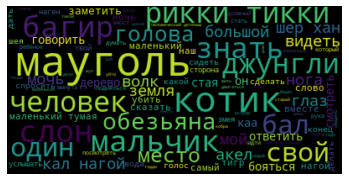

In [15]:
plot_cloud(p.normalize(preprocessed_text), filename='top100MostFreqWords', )

Найти все формы слова для top 10 самых часто используемые нормализованных слов в тексте.

In [16]:
def build_word_forms(word: str):
    forms = set()
    morph = MorphAnalyzer()
    parse_list = morph.parse(word);
    for parse in parse_list:
        lexeme = parse.lexeme
        for form in lexeme:
            forms.add(form.word)
    return list(forms)

top_10_forms: List[List[str]] = []
top_10_words: List[str] = [v[0] for v in top[:10]]

for word in top_10_words:
    top_10_forms.append(build_word_forms(word))
    
dict(zip(top_10_words, top_10_forms))

{'мауголь': ['маугли',
  'маугля',
  'мауглями',
  'мауголью',
  'мауглем',
  'мауглю',
  'маугле',
  'мауголею',
  'мауголями',
  'мауголях',
  'мауголе',
  'мауголи',
  'маугль',
  'мауглям',
  'мауглях',
  'мауглей',
  'мауголь',
  'мауголю',
  'мауголей',
  'мауглём',
  'мауголям',
  'мауголя'],
 'котик': ['котики',
  'котику',
  'котиках',
  'котиком',
  'котиками',
  'котика',
  'котиков',
  'котикам',
  'котик',
  'котике'],
 'слон': ['слонов',
  'слоны',
  'слонах',
  'слоне',
  'слон',
  'слонами',
  'слону',
  'слоном',
  'слонам',
  'слона'],
 'багир': ['багировичем',
  'багиров',
  'багиром',
  'багировне',
  'багировичам',
  'багировиче',
  'багировичами',
  'багирой',
  'багировной',
  'багировичи',
  'багирах',
  'багировен',
  'багире',
  'багира',
  'багировна',
  'багировну',
  'багировичей',
  'багировичу',
  'багировича',
  'багирам',
  'багирою',
  'багиру',
  'багирами',
  'багировнам',
  'багировнами',
  'багировны',
  'багиры',
  'багировнах',
  'багир',
  'баги

Найти все имена собственные.

In [17]:
class NewPreprocessor(Preprocessor):
    
    def string_prepro(self, sentence):
        string = sentence
        string = re.sub(r'(https|http)?:\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', string)
        string = re.sub(r'www\.\S+\.com', '', string)
        string = re.sub('<.*?>', '', string)
        string = re.sub(r'[A-Za-z]', '', string)
        string = re.sub(r'\d+', " ", string)
        string = string.replace('ё', 'е')
       # string = re.sub(r'[^\w\d\s]+', ' ', string)
       # string = ' '.join(string.split())
       # string = self.emoji_pattern.sub(r'', string)
        return string

In [18]:
# Перепишем препроцессор для того, чтобы он не удалял знаки препинания и не приводил все слова к нижнему регистру

new_p = NewPreprocessor()
new_preprocessed_text = new_p.string_prepro(text)
new_preprocessed_text

'\nБРАТЬЯ МАУГЛИ\n\n\n&;&; \n&;&;      В Сионийских горах наступил очень жаркий вечер. Отец Волк проснулся после дневного отдыха, зевнул, почесался и одну за другой вытянул свои передние лапы, чтобы прогнать из них остаток тяжести. Волчица Мать лежала, прикрыв своей большой серой мордой четверых барахтавшихся, повизгивавших волчат, а в отверстие их пещеры светила луна.\n&;&;      -- Огур!.. -- сказал Отец Волк. -- Пора мне идти на охоту.\n&;&;      И он уже готовился пуститься по откосу горы, когда маленькая тень с пушистым хвостом показалась подле входа в пещеру и жалобно провизжала:\n&;&;      -- Пусть тебе сопутствует удача, о вождь волков, пусть судьба даст твоим благородным детям сильные, белые зубы; пусть счастье улыбается им. И да не забывают они голодных!\n&;&;      Говорил шакал Табаки, лизоблюд. Волки Индии презирали Табаки за то, что он всем причинял неприятности, сплетничал и поедал тряпье и лоскутья кожи на сельских свалках мусора. Вместе с тем, в джунглях боялись его, пот

In [19]:
#!pip3 install pymorphy2==0.8
#!pip3 install spacy==2.1.9

#!git clone -b v2.1 https://github.com/buriy/spacy-ru.git && cp -r ./spacy-ru/ru2/. /.

import spacy

def entity_at(t):
    entity = [e for e in t.doc.ents if e.start == t.i]
    if entity:
        return entity[0].text
    return '' 

tokens = []

nlp = spacy.load('spacy-ru/ru2')
nlp.add_pipe(nlp.create_pipe('sentencizer'), first=True)
doc = nlp(text)
for token in doc:
    entity = entity_at(token)
    if entity != '':
        tokens.append(entity)

In [20]:
list(set(tokens))

['Сионийских горах',
 'Тихого океана',
 'Волком Отцом',
 'Слушайте Багиру',
 'Закон',
 'Багире',
 'Увидав Маугли',
 'Матка',
 'Сеговлийском военном поселении',
 'Икки',
 'Детеныш',
 'Стоило',
 'Покровитель Бедных',
 'Законам Джунглей',
 'Шиве',
 'Примем',
 'Нага',
 'Венгунги',
 'Али-Мушед',
 'Черного Тумаи',
 'Мертвым Волком',
 'Куттар Гудж',
 'Акелы',
 'ОХОТА',
 'Отец Волк',
 'Роса',
 'Справедливо',
 'Хаххх',
 'Мессуа',
 'Петерсену',
 'Раваль',
 'Магдале',
 'Белым Котиком',
 'Убийца Китов',
 'Одинокий Волк',
 'Вой Акелы',
 'Тумаи',
 'Керик',
 'Манг',
 'Эмир',
 'Луна',
 'Крик Пришельцев',
 'Бармао',
 'Дарси',
 'Юга',
 'Оркнейским',
 'Венгунгу',
 'Мачуа Аппы',
 'Мул Билли',
 'Акеле',
 'Трава',
 'Детеныш Матки',
 'Туземного пехотного полка',
 'Котику',
 'Ракша',
 'Удейпуре',
 'Маленький Тумаи',
 'Венгунга',
 'Бандар-логом',
 'Рикки',
 'Черного Змея',
 'Нагеной подле',
 'Холодных Логовищах',
 'Рикки-',
 'Хати',
 'Брат',
 'Нагене',
 'Совет',
 'Безногий',
 'Морской Свиньей',
 'Тут Балу',
 '

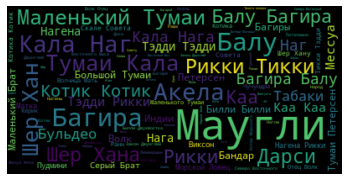

In [21]:
plot_cloud(tokens, filename='top100MostFreqNames')